# WHAT THIS DOES

1. Creates a folder called 'ssd-imagenet'
2. Takes imagenet raw data and converts it into a form for use with the ssd-7 model

In [61]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from shutil import copyfile

from PIL import Image
import pickle

In [94]:
def boundingBoxesSSD(max_folders=50):
    ssd_path = 'ssd-imagenet'
    if not os.path.isdir(ssd_path):
        os.makedirs(ssd_path)
    
    path = 'RealImageNet/'
    traindir = os.path.join(path, 'ImageNetSubsample', 'Data', 'CLS-LOC', 'train')
    boxesPath = os.path.join(path, "LOC_train_solution.csv")
    imageBoxes = [line.rstrip('\n').split(',') for line in open(boxesPath)][1:]
    
    filenames = []
    b1 = []
    b2 = []
    b3 = []
    b4 = []
    labels = []
    size = 224
    
   

    for boxes in imageBoxes:
        imageFileName = boxes[0] + ".JPEG"
        raw_imgpath = os.path.join(traindir, imageFileName.split('_')[0], imageFileName)
        if os.path.exists(raw_imgpath):
            img = Image.open(raw_imgpath)

            width, height = img.size

            x_ratio = width / size
            y_ratio = height / size
            boxesSplit = boxes[1].split()
        #     print(boxesSplit)

            for i in range(0, len(boxesSplit), 5):

                box = boxesSplit[i:i+5]
                label = box[0]
                box = box[1:]
                box = [int(b) for b in box]
                filenames.append(imageFileName)
                b1.append(int(box[0]/x_ratio))
                b2.append(int(box[1]/y_ratio))
                b3.append(int(box[2]/x_ratio))
                b4.append(int(box[3]/y_ratio))
                labels.append(label)



    df = pd.DataFrame({'image': filenames, 'xmin': b1, 'xmax': b3, 'ymin': b2, 'ymax': b4, 'class_id': labels})
    
    
    

        
    
    valid_images = []
   
    
    n = 0
    for folder in os.listdir(traindir):
        if n> max_folders:
            break
        if folder.startswith('n'):

            for f in os.listdir(os.path.join(traindir, folder)):
                if f.endswith('.JPEG'):
                    valid_images.append(f)
                    
        n += 1

    # valid_images
    valid_df = df[df.image.isin(valid_images)]
    classes = valid_df.class_id.unique()
    mapping = dict(zip(classes, range(len(classes))))
    valid_df = valid_df.replace({'class_id': mapping})
    
    with open(os.path.join(ssd_path, 'class_mapping.pickle'), 'wb') as handle:
        pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    df_train, df_val = train_test_split(valid_df, test_size=0.2)
    df_train.to_csv(os.path.join(ssd_path, 'labels_train.csv'), sep=',', index=False)
    df_val.to_csv(os.path.join(ssd_path, 'labels_val.csv'), sep=',', index=False)
    
    
    
#     outpath = '/Users/matt/work/ucsc/class/cmps240/project/ssd_keras/data/imagenet/'
    for img in valid_df.image:
        copyfile(os.path.join(traindir, img.split('_')[0], img), os.path.join(ssd_path, img))
    
    
    
    for f in os.listdir(ssd_path):
        if f.endswith('.JPEG'):
            img = Image.open(os.path.join(ssd_path, f))
            img = img.resize((size, size), Image.ANTIALIAS)
            img.save(os.path.join(ssd_path, f))
            
    return valid_df

In [95]:
df = boundingBoxesSSD(5)

In [96]:
def readMapping():
    d = {}
    ssd_path = 'ssd-imagenet'
    with open(os.path.join(ssd_path, 'class_mapping.pickle'), 'rb') as handle:
        d = pickle.load(handle)
    return d

readMapping()

{'n01440764': 0,
 'n01491361': 1,
 'n01484850': 2,
 'n01494475': 3,
 'n01443537': 4}

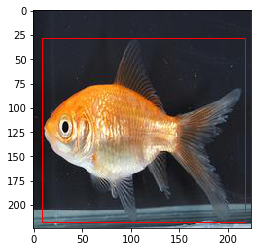

In [97]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
path = 'RealImageNet/'
traindir = os.path.join(path, 'ImageNetSubsample', 'Data', 'CLS-LOC', 'train')
ssd_path = 'ssd-imagenet'
df =  pd.read_csv(os.path.join(ssd_path, 'labels_train.csv'))
num = 22
imgname = df.image[num]
xmin = df.xmin[num]
xmax = df.xmax[num]
ymin = df.ymin[num]
ymax = df.ymax[num]

raw_imgpath = os.path.join(traindir, imgname.split('_')[0], imgname)
new_imgpath = os.path.join(ssd_path, imgname)
img = Image.open(new_imgpath)

width, height = img.size
size = 224

from matplotlib import pyplot as plt
%matplotlib inline


im = np.array(Image.open(new_imgpath), dtype=np.uint8)
# plt.imshow(im)
# # Create figure and axes
fig,ax = plt.subplots(1)

# # Display the image
ax.imshow(im)

# # Create a Rectangle patch
rect = patches.Rectangle((xmin, ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

# # Add the patch to the Axes
ax.add_patch(rect)

plt.show()

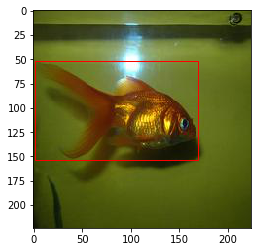

In [78]:
x_ratio = width / size
y_ratio = height / size

xmin_new = xmin/x_ratio
xmax_new = xmax/x_ratio
ymin_new = ymin/y_ratio
ymax_new = ymax/y_ratio

new_imgpath = os.path.join(ssd_path, imgname)
img = Image.open(new_imgpath)
im = np.array(Image.open(new_imgpath), dtype=np.uint8)
fig,ax = plt.subplots(1)

# # Display the image
ax.imshow(im)
rect = patches.Rectangle((xmin_new, ymin_new),(xmax_new-xmin_new),(ymax_new-ymin_new),linewidth=1,edgecolor='r',facecolor='none')

# # Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [45]:
raw_imgpath

'RealImageNet/ImageNetSubsample/Data/CLS-LOC/train/n01494475/n01494475_7626.JPEG'